# 실시간 알약 인식기

촬영된 사진으로부터 알약의 색상과 모양을 식별한다.

- 김동주 <hepheir@gmail.com>
- 박원우 <pww5148@gmail.com>

![](https://www.pharm.or.kr/images/sb_photo/big3/A11A1310A007101.jpg)

# 선정이유

Apple이나 Samsung과 같은 유명 휴대폰 제조사의 건강 애플리케이션에서 투여약을 추가할 경우, 다음과 같이 사용자가 직접 이름과 용량, 종류, 모양, 색상을 입력해야 한다.

![](../images/apple-건강-앱.png)

촬영을 통해 사용자가 쉽고 편하게 알약의 정보를 알 수 있도록 하고자 이 프로젝트를 선정하였으며, 남녀노소 누구나 쉽게 알아 볼 수 있는 인포그래픽의 형태로 정보를 제공하고자 하였다.

---

In [1]:
import math
import typing
import colorgram
import cv2
import numpy as np
import matplotlib.pyplot as plt
import webcolors
from PIL import Image

우선 파일을 불러오자.

In [2]:
raw_images = [
    cv2.imread('../images/IMG_9652.png'),
    cv2.imread('../images/IMG_9653.png'),
    cv2.imread('../images/IMG_9654.png'),
    cv2.imread('../images/IMG_9796.png'),
    cv2.imread('../images/IMG_9797.png'),
    cv2.imread('../images/IMG_9798.png'),
    cv2.imread('../images/IMG_9801.png'),
    cv2.imread('../images/IMG_9863.png'),
]

n_images = len(raw_images)

In [3]:
def plot_images(images: typing.Tuple[np.ndarray]):
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i+1)
        hide_ticks()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def hide_ticks():
    plt.tick_params(left=False,
                    right=False,
                    labelleft=False,
                    labelbottom=False,
                    bottom=False)


영상처리를 하기에 앞서, 여러 이미지에 대해 비슷한 결과를 출력하길 바라는 마음에 이미지의 일부를 추출하여 업샘플링/다운샘플링하여 사용할 것이다.

너비와 높이 중 짧은 것의 80%를 한 변의 길이로 하는 정사각형을 추출하여 사용하겠다.

그리고, 항상 고정된 해상도 512x512를 기준으로 영상을 처리하겠다.

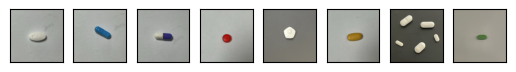

In [4]:
def normalize_shape(mat2d: np.ndarray, size: int = 512, radius_ratio: float = 0.4):
    cy, cx = mat2d.shape[0]/2, mat2d.shape[1]/2
    radius = radius_ratio * min(mat2d.shape[:2])

    y_min = int(cy-radius)
    y_max = int(cy+radius)
    x_min = int(cx-radius)
    x_max = int(cx+radius)

    return cv2.resize(mat2d[y_min:y_max, x_min:x_max, :], (size, size))

images = list(map(normalize_shape, raw_images))
plot_images(images)

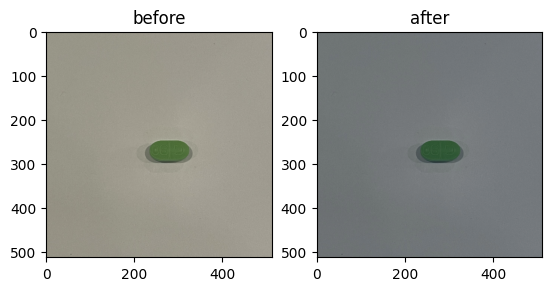

In [18]:
def f(image):
    # Convert the image to the LAB color space
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Create an instance of the SimpleWB class
    awb = cv2.xphoto.createGrayworldWB()

    # Apply automatic white balance correction
    image_balanced = awb.balanceWhite(image_lab)

    # Convert the image back to the original color space
    image_result = cv2.cvtColor(image_balanced, cv2.COLOR_LAB2BGR)
    return image_result


before = images[-1]
after = f(before)

plt.subplot(121)
plt.imshow(cv2.cvtColor(before, cv2.COLOR_BGR2RGB))
plt.title('before')
plt.subplot(122)
plt.imshow(cv2.cvtColor(after, cv2.COLOR_BGR2RGB))
plt.title('after')
plt.show()

# 영상 분석

이제, 어떻게 하면 위 이미지로부터 알약을 찾을 수 있을 지 알아보자.

입력된 이미지에서 각 픽셀의 값들이 RGB 공간에서 어떻게 분포되어있는지를 보고자 한다.

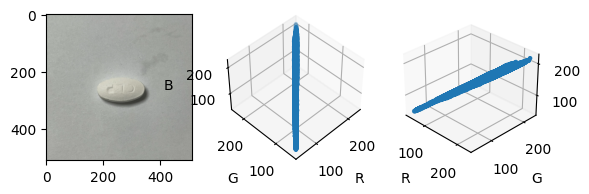

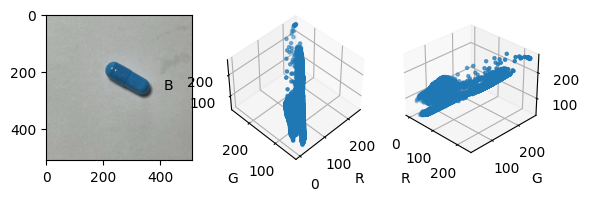

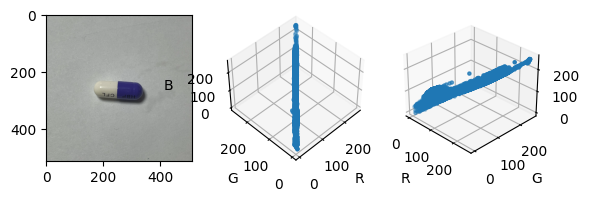

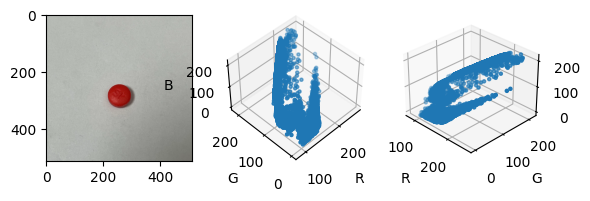

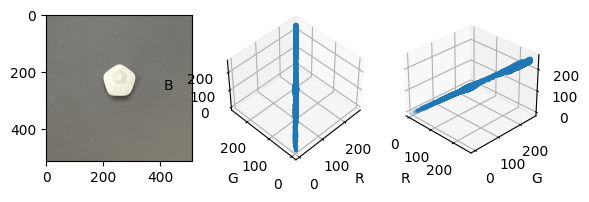

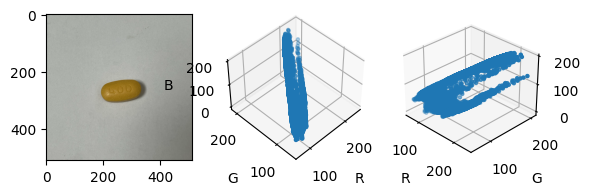

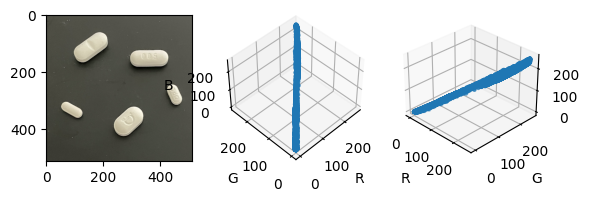

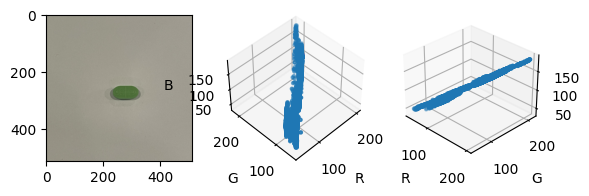

In [6]:
def analyze_in_rgb_space(image: np.ndarray):
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    r, g, b = cv2.split(rgb_image)

    fig = plt.figure()

    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(rgb_image)

    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    ax2.scatter(r, g, b, marker='.')
    ax2.set_xlabel('R')
    ax2.set_ylabel('G')
    ax2.set_zlabel('B')
    ax2.view_init(45, -135)

    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    ax3.scatter(r, g, b, marker='.')
    ax3.set_xlabel('R')
    ax3.set_ylabel('G')
    ax3.set_zlabel('B')
    ax3.view_init(30, -45)

    plt.show()

for img in images:
    analyze_in_rgb_space(img)

x, y, z 축이 균일하게 상승하는 중앙 곡선은 아마도 무채색의 배경일 것이다.

그리고, 한 쪽으로 튀어나온 부분이 파란색의 알약이 있는 부분 일 것이다.

잠깐 정리하고 넘어가보자면, 이미지로 부터 알약을 찾기 위해 필요한 정보는 다음과 같다.

1. 알약의 색상
2. 알약의 모양
3. (...)

# 색상 추출

알약의 색상을 찾기위해서는 우선 채도를 바탕으로 색이 있는지 없는지를 판단할 필요가 있다. 색상이 있다고 판단되면 그 때 색상을 찾는다.

색상이 있고 없음을 구분지을 수 있는 속성은 아무래도 채도일 것이다. 
특히 조명에 의한 밝기 변화 대하여 채도는 명도에 비해 영향을 덜 받기 때문에 조명에도 강할 것이다.

관련 색 공간으로 기저를 변환해 보는 것이 좋을 것 같다.

RGB -> HSV로 변환해본 후, 각 픽셀의 채도를 출력하여, 채도가 알약 검출에 사용될 수 있을지를 가늠해보자.

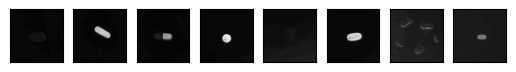

In [7]:
def select_saturation_channel(bgr_image: np.ndarray) -> np.ndarray:
    hsv_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    return s

gray_images = list(map(select_saturation_channel, images))
plot_images(gray_images)

채도에 대한 채널만 출력했음에도 마스크 이미지에 가까운 결과를 얻을 수 있었다.

흑백이미지를 이진(마스크)이미지로 만들기 위해 임계값처리를 해주고,
노이즈를 제거하기 위해 모폴로지 연산을 수행해볼 것이다.

먼저 임계값 처리를 하기 위해, 히스토그램 분석을 통해 적절한 임계값을 찾는다.

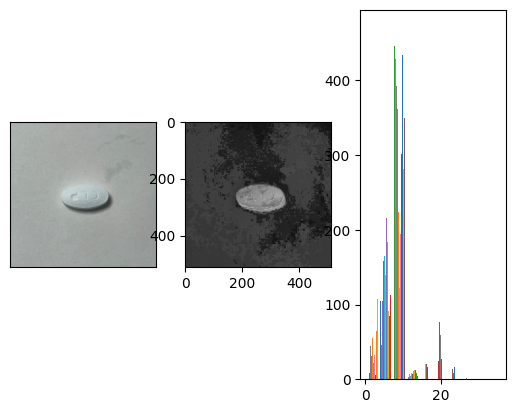

std: 3.41


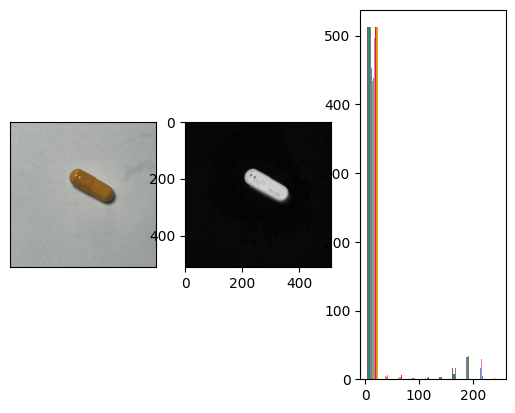

std: 33.26


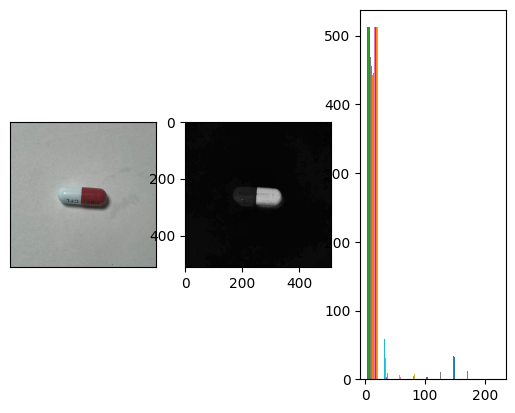

std: 19.02


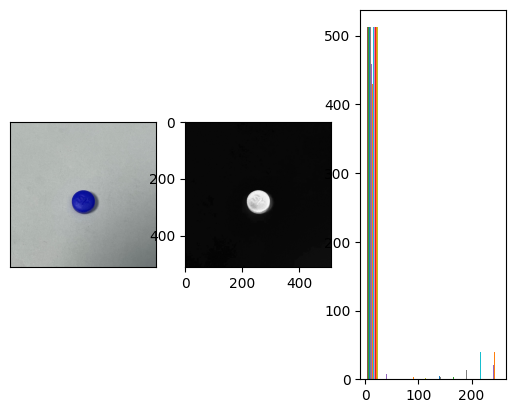

std: 29.81


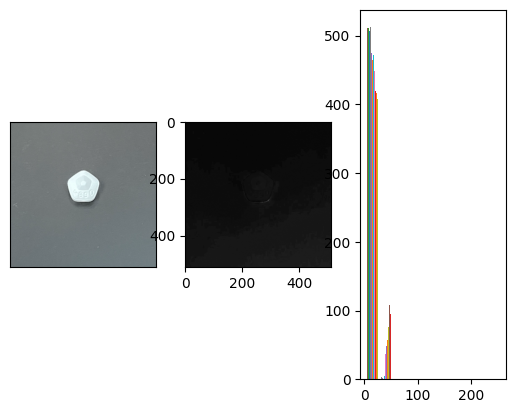

std: 6.45


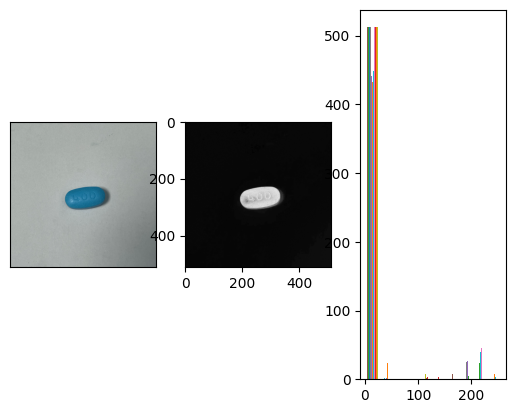

std: 35.48


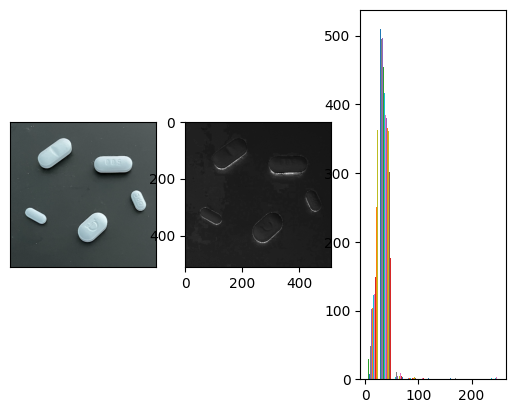

std: 13.20


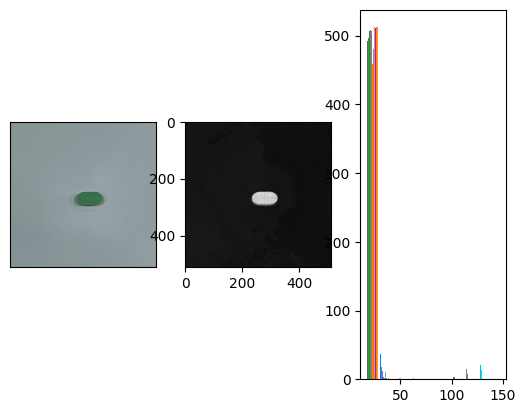

std: 11.08


In [8]:
for i in range(len(images)):
    plt.subplot(131)
    hide_ticks()
    plt.imshow(images[i])

    plt.subplot(132)
    plt.imshow(gray_images[i], cmap='gray')

    plt.subplot(133)
    plt.hist(gray_images[i])

    plt.show()
    print(f'std: {gray_images[i].ravel().std():.2f}')

낮은 값에 배경이 몰려있고, 약 [160, 220] 값 사이에 알약이 위치했음으로 추정해 볼 수 있을 것 같다.

우리는 눈으로 보고 적절히 150에서 임계값을 잡으면 될 것이라고 생각해 볼 수 있겠으나, 다양한 이미지로부터 알약을 찾도록 확장한다고 생각해보면 매번 사용자가 직접 임계값을 설정하는 것은 굉장히 비효율적이며 부적절할 것이다.

임계값을 자동으로 찾기위한 여러 알고리즘 중, Otsu의 이진화 알고리즘을 사용해보려고 한다.

Otsu 알고리즘은 두 클래스의 분산을 최소화시키는 임계값을 찾기위한 알고리즘이다.

<figure>
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/34/Otsu%27s_Method_Visualization.gif/440px-Otsu%27s_Method_Visualization.gif"/>
    <figcaption>Otsu's method visualization</figcaption>
</figure>

https://en.wikipedia.org/wiki/Otsu%27s_method

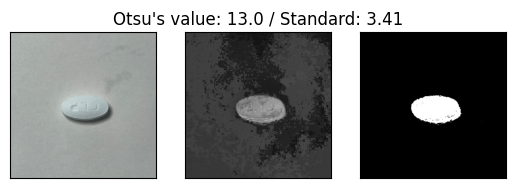

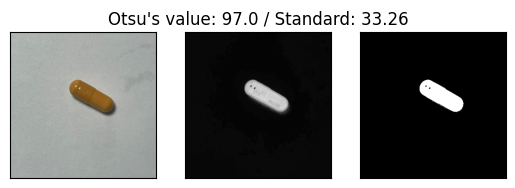

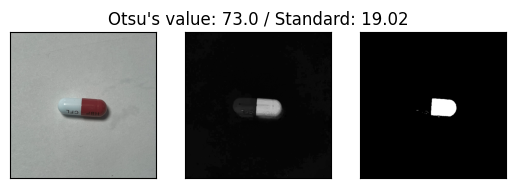

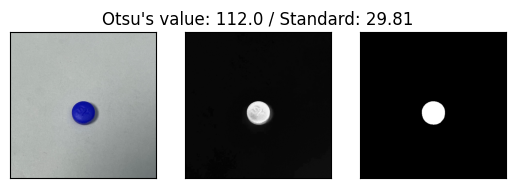

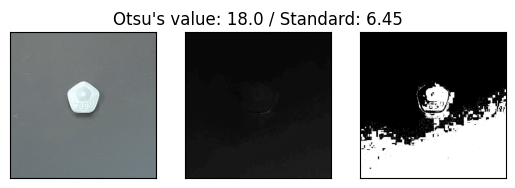

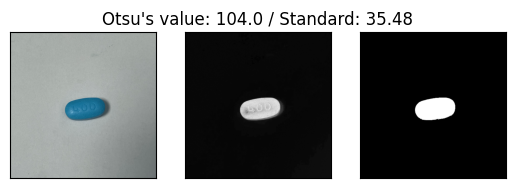

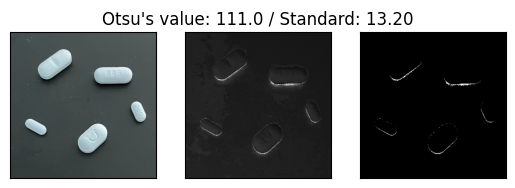

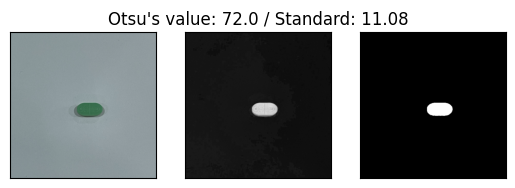

In [9]:
bin_images = [None] * len(images)

for i in range(len(images)):
    otsu_value, bin_images[i] = cv2.threshold(gray_images[i], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    plt.subplot(131)
    hide_ticks()
    plt.imshow(images[i])
    plt.subplot(132)
    hide_ticks()
    plt.imshow(gray_images[i], cmap='gray')
    plt.title(f"Otsu's value: {otsu_value} / Standard: {gray_images[i].ravel().std():.2f}")
    plt.subplot(133)
    hide_ticks()
    plt.imshow(bin_images[i], cmap='gray')
    plt.show()

Otsu의 이진화 알고리즘은 97을 임계값으로 설정한 것 같다.
나쁘지 않아보이므로, 이를 그대로 사용해보겠다.

이어서, 모폴로지 침식-팽창 시퀀스로 점노이즈를 제거해주었고, 팽창-침식 시퀀스로 홀을 제거해주었다.

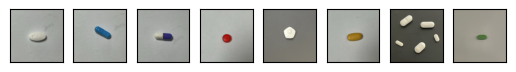

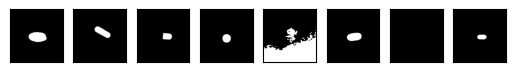

In [10]:
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))

for i in range(n_images):
    bin_images[i] = cv2.morphologyEx(bin_images[i], cv2.MORPH_OPEN, se)
    bin_images[i] = cv2.morphologyEx(bin_images[i], cv2.MORPH_CLOSE, se)

plot_images(images)
plot_images(bin_images)

만약에 에지를 기준으로 검출했다면 어땠을까...

In [11]:
import collections
import sys

sys.setrecursionlimit(int(1e6))


STRUCTURING_ELEMENT = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))


def by_edge_detection(image: np.ndarray) -> np.ndarray:
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_img = fft_filter(gray_img, inverse_gaussian_2d_filter(gray_img.shape, 4.5))
    bin_img = cv2.threshold(
        gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[-1]
    bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, STRUCTURING_ELEMENT)
    bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, STRUCTURING_ELEMENT)
    bin_img = _remove_border_elements(bin_img)
    contours = cv2.findContours(
        bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    out_img = np.zeros_like(bin_img)
    cv2.drawContours(out_img, contours, -1, 255, -1)
    return out_img


def inverse_gaussian_2d_filter(shape: typing.Tuple[int], radius: int) -> np.ndarray:
    return 1 - gaussian_2d_filter(shape, radius)


def gaussian_2d_filter(shape: typing.Tuple[int], radius: int) -> np.ndarray:
    h, w = shape[:2]
    cy, cx = h/2, w/2
    X, Y = np.meshgrid(np.linspace(1, w, w), np.linspace(1, h, h))
    return np.exp(-(np.power(X-cx, 2)+np.power(Y-cy, 2)) / (2*np.power(radius, 2)))


def fft_filter(gray: np.ndarray, filter: np.ndarray) -> np.ndarray:
    if len(gray.shape) != 2:
        raise ValueError()
    fft = np.fft.fft2(np.float32(gray))
    fft_shift = np.fft.fftshift(fft)
    fft_ishift = np.fft.ifftshift(fft_shift * filter)
    ifft = np.fft.ifft2(fft_ishift)
    return np.uint8(cv2.magnitude(ifft.real, ifft.imag))


def _remove_border_elements(bin_image: np.ndarray) -> np.ndarray:
    q = collections.deque()
    h, w = bin_image.shape[:2]
    for x in range(w):
        q.append((0, x))
        q.append((h-1, x))
    for y in range(h):
        q.append((y, 0))
        q.append((y, w-1))
    while q:
        y, x = q.popleft()
        _remove_border_elements_util(bin_image, y, x)
    return bin_image


def _remove_border_elements_util(mat: np.ndarray, y: int, x: int):
    if not check_indicies(mat, y, x):
        return
    if not mat[y, x]:
        return
    mat[y, x] = 0
    for dy, dx in ((-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)):
        _remove_border_elements_util(mat, y+dy, x+dx)


def check_indicies(mat: np.ndarray, *args: int) -> bool:
    if len(args) > len(mat.shape):
        raise ValueError()

    for arg in args:
        if arg < 0:
            return False

    for axis, arg in enumerate(args):
        if arg >= mat.shape[axis]:
            return False

    return True

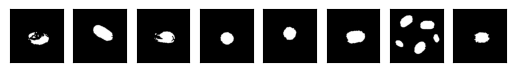

In [12]:
bin_images_e = list(map(by_edge_detection, images))
plot_images(bin_images_e)

In [13]:
plt.imshow(cv2.copyTo(image, bin_image))

NameError: name 'image' is not defined

# 색상이 없다면?

만약에 색상이 없는 알약은 어떻게 검출해야 할까.
이 경우에는 알약의 에지를 검출하거나, 그 외에 다른 방법을 사용해야 한다.
에지를 검출할 경우 그림자가 에지성분에 포함될 수 있는 문제가 있다.

향후 모양 판별을 함에 있어 마스크 이미지의 정확도가 상당히 중요한 요인이기 때문에, 에지 검출을 이용한다면 꽤 많은 어려움을 겪게 된다.

따라서, 본 실습에서는 그레이 스케일의 알약에 대해서는 배경을 알약과 확연히 다른 색상으로 선택하여 알약을 구분하는 것으로 대채한다. 물론 이 경우에는 HSV대신 다른 색공간을 이용하는 것 또한 고려해봐야 한다.
(예: 하얀 알약에 대해서는 검정색 배경 사용 -> 밝기 값 사용)

# 그래서 이 색상은 무엇인가

알약의 위치를 특정했으니, 이 알약의 색이 무엇인지를 알아낼 수 있어야 한다.

이는 다음과 같이 특정할 것이다.

1. 알약의 원본 이미지로 부터 마스크 이미지를 사용해 배경을 제거한다.
2. 배경이 제거된 영상에서 픽셀별 색상 분포에 대한 통계를 낸다.
3. 가장 많은 색상은 배경색상이므로, 두 번째로 가장 많은 색상이 알약의 색상이 된다.

2번에서 통계를 내는 과정은 외부 라이브러리(colorgram.py)를 사용한다.

In [ ]:
# 마스킹을 통해 알약의 영역만 추출
pill_image = cv2.copyTo(rgb_image, bin_image)

# 다운샘플링으로 처리속도 개선
# (colorgram.extract() 는 작업 시간이 크다. 실행시간 단축을 위해 다운샘플링을 사용한다.)
down_sampled_image = cv2.resize(pill_image, (64, 64))

pillow_image = Image.fromarray(down_sampled_image)
colors: typing.List[colorgram.Color]
colors = colorgram.extract(pillow_image, number_of_colors=2)

# 두 번째로 많은 색상 추출
pill_color = colors[1].rgb

plt.imshow(np.full((1, 1, 3), pill_color))

알약을 대표하는 색상의 R, G, B는 알게 되었지만, 이 색을 부르는 명칭에 대해서는 우리는 아직 모른다.

가장 가까운 색상을 찾는 코드를 통해, 이 색상의 이름을 알아보자.

약학정보원에서 선택가능한 색상들의 RGB 값들을 가져온 후, 가져온 색들과 알약의 색과 3차원에서의 거리를 구한다.
구해진 거리를 바탕으로 가장 가까운 색상을 선택한다.

![](../images/약학정보원-검색창.png)

In [ ]:
# 약학 정보원의 색상들
sample_colors = {
    'white': webcolors.hex_to_rgb('#ffffff'),
    'yellow': webcolors.hex_to_rgb('#ffeb3b'),
    'orange': webcolors.hex_to_rgb('#ff9800'),
    'pink': webcolors.hex_to_rgb('#ff65d5'),
    'red': webcolors.hex_to_rgb('#ff0000'),
    'brown': webcolors.hex_to_rgb('#ab4723'),
    'lime': webcolors.hex_to_rgb('#8bc34a'),
    'green': webcolors.hex_to_rgb('#00962f'),
    'bluegreen': webcolors.hex_to_rgb('#0080a9'),
    'blue': webcolors.hex_to_rgb('#4269ff'),
    'navy': webcolors.hex_to_rgb('#1028ad'),
    'wine': webcolors.hex_to_rgb('#b90076'),
    'purple': webcolors.hex_to_rgb('#9b00b5'),
    'gray': webcolors.hex_to_rgb('#9e9e9e'),
    'black': webcolors.hex_to_rgb('#000000'),
}

def calc_color_distance(c1, c2):
    return math.sqrt(sum(map(lambda x: ((x[0]-x[1])**2), zip(c1, c2))))

closest_colors = sorted(sample_colors.items(), key=lambda color: calc_color_distance(color[1], pill_color))
print(closest_colors)

pill_color = closest_colors[0][1]
pill_color_name = closest_colors[0][0]

plt.imshow(np.full((1, 2, 3), pill_color))
plt.title(pill_color_name)

예시로 사용한 알약에서 검출된 색상은 `bluegreen`. 즉, 청록색이다.

# 모양 판별

이제 모양을 판별할 차례이다.

모양을 판별하는 방법으로는 Correlation 패턴인식 혹은 윤곽선 검출 응용등의 방법이 있다.

처음에는 이 중에서 Correlation 패턴인식을 사용해 볼 생각이었으나, 곧 해당 방법의 효용성에 의문이 들기 시작했다.
알약의 모양은 크게 원형, 장방형, 원통형, 삼각형 등 유사한 범주로 구분이 가능하지만, 알약마다 변의 길이가 제각각이기에 Correlation 만으로는 이들을 구분하기 어려울 것 같다는 생각이 들었다.

따라서, 윤곽선을 이용한 검출 방법을 택하기로 하였다.

먼저 위 이미지에서 윤곽선을 검출한다.

In [ ]:
contours = cv2.findContours(bin_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2]

이제 검출한 윤곽선으로 부터 모양을 추출할 것이다.

모양을 추출하는 방법으로는 꼭짓점의 개수를 헤아리는 것으로 근사하게 추출 할 수 있다.

가령 꼭짓점이 3개가 검출되었다면 이는 삼각형임을 의미하고, 꼭짓점이 없다(무수히 많다)의 경우 이는 원이라고 판단할 수 있다.

하지만 2차원 이미지에서 얻어진 윤곽선은 울퉁불퉁한 픽셀들로부터 추출한 윤곽선이므로 원치않는 꼭짓점 노이즈가 검출되는 일이 잦을 수 밖에 없다. 따라서, 윤곽선을 근사시키는 방법을 활용한다. 근사의 기준이 되는 근사치 정확도는 둘레의 총 길이의 일정 비율(4%)로 설정하여, 서로다른 크기의 유사한 모양에 대해서도 효과적이도록 설계할 것이다.

여기서 어려운 부분은 원형과 타원형, 그리고 장방형의 구분이다. 

아래 코드에서는 구분하기 쉬운 삼각형, 사각형 그리고 오각형을 우선적으로 구분한다.

In [ ]:
print(f'{len(contours)} contours found.')

if len(contours) > 1:
    raise Exception('아직 동시에 여러 개의 알약은 검출하기 어렵습니다.')

contour = contours[0]
approx = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)
n_approx = len(approx) # 꼭짓점의 개수

if n_approx == 3:
    print('triangle')
elif n_approx == 4:
    print('quadrilateral')
elif n_approx == 5:
    print('pentagon')
else:
    print('circle? oval? rectangular?')
    print(n_approx)

찾아진 윤곽선과 꼭짓점들을 표시하면 다음과 같이 나타낼 수 있다.

In [ ]:
temp_image = np.zeros((512, 512, 3), dtype=np.uint8)
temp_image[bin_image == 255,:] = 255
cv2.drawContours(temp_image, [contour], 0, (255, 0, 0), 2)

x = approx[:,:,0]
y = approx[:,:,1]

plt.subplot(121)
plt.imshow(bin_image, cmap='gray')

plt.subplot(122)
plt.imshow(temp_image, cmap='gray')
plt.scatter(x, y, marker='o')

# 모양판별 Tie break

(circle, oval, rectangular)

이제 구분이 어려운 모양들을 구분 할 것이다.

<figure>
    <img src="../images/IMG_9801.png" height="320"/>
    <img src="../images/약학정보원-모양선택.png" height="320"/>
    <figcaption>패턴인식으로 구별이 어려운 장방형 알약들</figcaption>
</figure>

In [ ]:
def create_pill_mask(image, is_colored=True):
    pass

# 한계

- 아직은 무채색의 알약에는 강하지 못함.
- 균일한 배경에 대해서만 원활하게 동작함
- 동시에 여러 개의 알약은 감지하지 못함.
- 아직은 원형(circle)-타원형(oval)-장방형(rectangular)을 깔끔하게 구분하지 못함.